In [1]:
# 라이브러리 임포

import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [2]:
# 1. 데이터 로드 함수 (CNN과 동일)

def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# 여러 파일을 3D 배열로 묶기
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    loaded = np.dstack(loaded)
    return loaded

# train/test 그룹 로드
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    filenames = [
        'total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt',
        'body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt',
        'body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt'
    ]
    X = load_group(filenames, filepath)
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

# 전체 데이터셋 로드
def load_dataset(prefix=''):
    dataset_path = '/content/drive/MyDrive/Colab Notebooks/기계학습프로그래밍/10주/UCI HAR Dataset/'
    trainX, trainy = load_dataset_group('train', dataset_path)
    testX, testy = load_dataset_group('test', dataset_path)

    trainy -= 1
    testy -= 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)

    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

# 2. 데이터 불러오기 및 분할

trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

X_train, X_val, y_train_one_hot, y_val_one_hot, y_train, y_val = train_test_split(
    trainX, trainy_one_hot, trainy,
    test_size=0.2,
    random_state=100
)

print(X_train.shape, X_val.shape, y_train_one_hot.shape, y_val_one_hot.shape)

/tmp/ipython-input-612097512.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-612097512.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-612097512.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-612097512.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)
(5881, 128, 9) (1471, 128, 9) (5881, 6) (1471, 6)


In [3]:
# 3. GRU 모델 정의

n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

gru_model = Sequential([
    GRU(64, return_sequences=True, input_shape=(n_timesteps, n_features)),
    Dropout(0.3),
    GRU(32),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(n_outputs, activation='softmax')
])

gru_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
gru_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 128, 64)        │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,310 (102.77 KB)

 Trainable params: 26,310 (102.77 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# 4. 학습

history = gru_model.fit(
    X_train, y_train_one_hot,
    epochs=30,
    batch_size=64,
    validation_data=(X_val, y_val_one_hot),
    verbose=1
)

Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.3665 - loss: 1.5269 - val_accuracy: 0.5350 - val_loss: 1.0438
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5675 - loss: 1.0112 - val_accuracy: 0.6329 - val_loss: 0.8794
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6871 - loss: 0.7567 - val_accuracy: 0.7573 - val_loss: 0.5301
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7822 - loss: 0.5034 - val_accuracy: 0.8212 - val_loss: 0.4236
Epoch 5/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8171 - loss: 0.3994 - val_accuracy: 0.8137 - val_loss: 0.3945
Epoch 6/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8788 - loss: 0.3172 - val_accuracy: 0.9205 - val_loss: 0.2176
Epoch 7/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9216 - loss: 0.2315 - val_accuracy: 0.9103 - val_loss: 0.2130
Epoch 8/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9337 - loss: 0.1868 - val_accuracy: 0.9443 - v

In [5]:
# 5. 평가

loss, acc = gru_model.evaluate(testX, testy_one_hot, verbose=0)
print(f'Test Accuracy: {acc:.4f}')

Test Accuracy: 0.9108


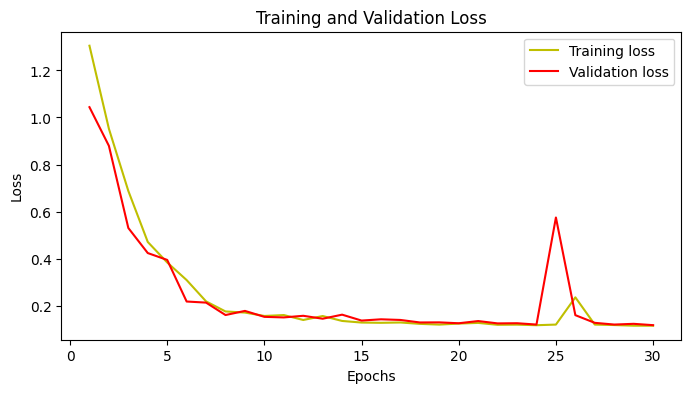

In [6]:
# 6. 학습 결과 시각화

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# 손실 그래프

plt.figure(figsize=(8, 4))
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

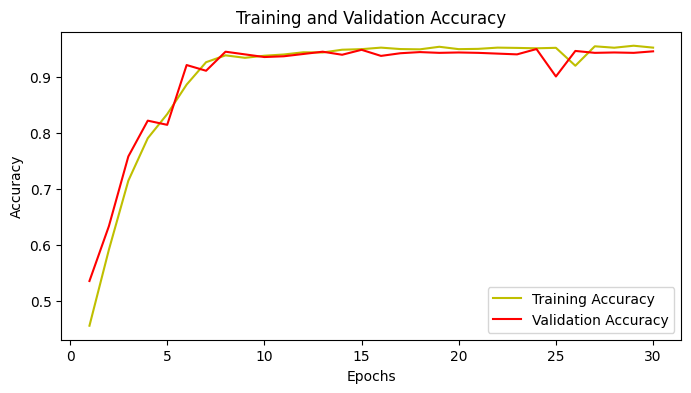

In [7]:
# 정확도 그래프

plt.figure(figsize=(8, 4))
plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
✅ Test Accuracy: 0.9107567017305734

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.92      0.95       496
           1       0.90      0.97      0.93       471
           2       0.92      1.00      0.96       420
           3       0.86      0.76      0.81       491
           4       0.81      0.88      0.84       532
           5       1.00      0.95      0.97       537

    accuracy                           0.91      2947
   macro avg       0.91      0.91      0.91      2947
weighted avg       0.91      0.91      0.91      2947



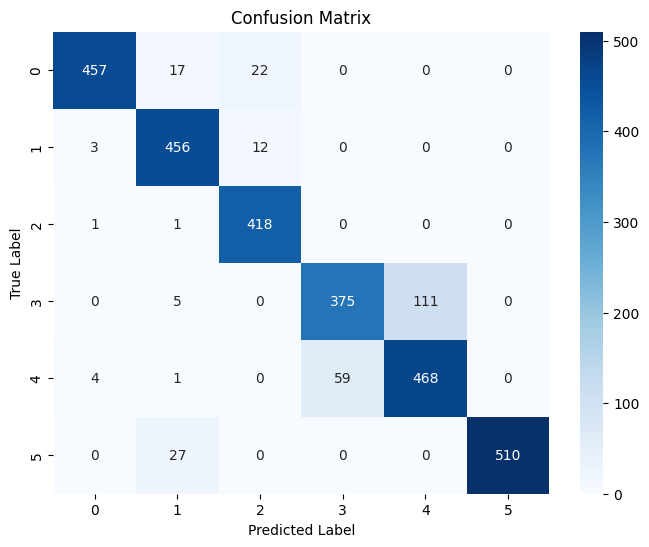

In [8]:
# 7. 테스트셋 평가 및 시각화

pred = gru_model.predict(testX)
pred = np.argmax(pred, axis=-1)
true = np.argmax(testy_one_hot, axis=-1)

print("✅ Test Accuracy:", accuracy_score(true, pred))
print("\n📊 Classification Report:\n", classification_report(true, pred))

cm = confusion_matrix(true, pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()